In [1]:
import pandas as pd

df = pd.read_csv('confirm_drop0.csv', 
    dtype={'id':int, 'Date':object, 'inc':int}, 
    parse_dates=['Date'], 
    infer_datetime_format=True)
df.head(5)

,Date,id,inc,inc_id
0,2020-01-24,638,1,0
1,2020-01-26,109,1,0
2,2020-01-26,214,1,0
3,2020-01-26,225,1,0
4,2020-01-29,1275,1,0


In [3]:
df.describe()

,id,inc,inc_id
count,1.132681e+06,1.132681e+06,1.132681e+06
mean,1.624442e+03,3.131630e+01,5.729076e+00
std,9.721196e+02,7.267180e+01,1.449539e+01
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,7.510000e+02,2.000000e+00,0.000000e+00
50%,1.591000e+03,7.000000e+00,1.000000e+00
75%,2.438000e+03,2.400000e+01,4.000000e+00
max,3.335000e+03,4.990000e+02,9.900000e+01


1859.903119868637


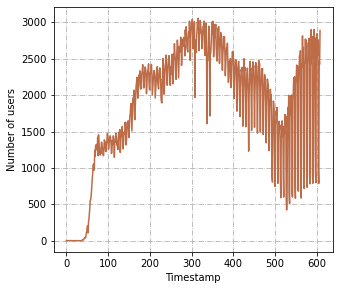

In [2]:
interval = pd.Timedelta('1d')
current_time = pd.Timestamp('2020-01-23')
l = []
for t in range(609):
    data = df.loc[df['Date']==current_time]
    l.append(len(data))
    current_time += interval

import numpy as np
print(np.mean(l))

import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4.5))
plt.plot(l, '-', color='#bd6c48')
plt.xlabel('Timestamp')
plt.ylabel('Number of users')
plt.grid(linestyle='-.')
plt.savefig('covid_user.pdf')
plt.show()

In [24]:
interval = pd.Timedelta('7d')
current_time = pd.Timestamp('2020-01-23')
l = []
for t in range(87):
    data = df.loc[df['Date']==current_time]
    l.append(len(data[data['id']==1252]))
    current_time += interval

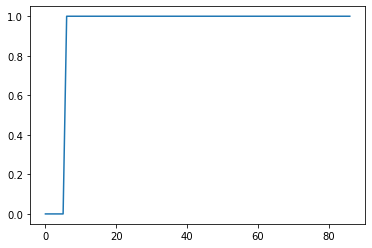

In [25]:
import matplotlib.pyplot as plt

plt.plot(l)
plt.show()

In [16]:
def MAE(freq, est_freq):
    return (abs(freq - est_freq)).mean()
def MRE(freq, est_freq):
    return (abs(np.dot(freq, np.arange(d)) - np.dot(est_freq, np.arange(d))))/(np.dot(freq, np.arange(d)) + np.finfo(np.float32).eps)
def jaccard_index(freq, est_freq, k):
    top_k = np.argpartition(-freq, k)[:k]
    est_top_k = np.argpartition(-est_freq, k)[:k]
    return len(np.intersect1d(top_k, est_top_k))/len(np.union1d(top_k, est_top_k))
def MSE(freq, est_freq):
    return (np.square(freq - est_freq)).mean()
def RMSE(freq, est_freq):
    return np.sqrt((np.square(freq - est_freq)).mean())

import numpy as np
from math import exp

from tqdm import trange

n = 3336
episode = 87
d = 100
universe = np.arange(d)

p_mat = np.zeros((d, d))
for i in range(d):
    p_mat[i] = np.abs(universe[i] - universe)*100

w = 30
epsilon = 1
epsilon_range = np.arange(0.1, 1.1, 0.1)
w_range = np.arange(5, 85, 5)
# [0.04931640625, 
#                 1.8316650390625, 
#                 9.9993896484375, 
#                 14.99908447265625, 
#                 19.9993896484375, 
#                 24.999237060546875, 
#                 29.99908447265625, 
#                 34.99946594238281, 
#                 39.9993896484375, 
#                 44.99931335449219, 
#                 49.999237060546875]
interval = pd.Timedelta('7d')
start_time = pd.Timestamp('2020-01-23')

## Uniform

In [13]:
for epsilon in epsilon_range:
# for w in w_range:
    current_time = start_time

    util = []
    for t in range(episode):
        data = df.loc[df['Date']==current_time]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.inc_id] += 1
            # randomization
            release_budget = epsilon/w
            exp_prob = np.exp(-release_budget*p_mat[row.inc_id]/2)
            exp_prob /= exp_prob.sum()
            private_inc = np.random.choice(universe, p=exp_prob)
            private_freq[private_inc] += 1
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        util.append(RMSE(true_freq, private_freq))
    print(np.mean(util))

135.26718393276406
113.27353002867164
95.7260107664099
81.4551256837889
69.7916240689482
59.509343886562284
50.14309676576762
43.27866213919368
36.74716217460917
31.41525282836182


In [37]:
for epsilon in epsilon_range:
# for w in w_range:
    window = np.zeros((n, episode), dtype=float)
    # historical data
    storage = [[] for _ in range(n)]

    current_time = start_time

    util = []
    for t in range(episode):
        data = df.loc[df['Date']==current_time]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.inc_id] += 1
            release_budget = epsilon/(w*0.45)
            remain = epsilon - window[row.id][max(0, t-w+1):t].sum()
            if remain < release_budget:
                release_budget = 0
            if release_budget > 0:
                # randomization
                exp_prob = np.exp(-release_budget*p_mat[row.inc_id]/2)
                exp_prob /= exp_prob.sum()
                private_inc = np.random.choice(universe, p=exp_prob)
                # update window
                window[row.id][t] = release_budget
                storage[row.id].append(private_inc)
            else:
                private_inc = storage[row.id][len(storage[row.id])-1]
            private_freq[private_inc] += 1
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        util.append(RMSE(true_freq, private_freq))
    print(np.mean(util))

85.62347717396977
54.97090769398711
36.91854269750659
31.008414558546473
20.36995421141204
30.266206404334206
24.491373306296392
24.101762199130775
20.64443284184223
15.94632175425377


## Local Sample

In [8]:
# for epsilon in epsilon_range:
for w in w_range:
    window = np.zeros((n, episode), dtype=float)
    # historical data
    storage = [[] for _ in range(n)]

    current_time = start_time

    util = []
    for t in range(episode):
        data = df.loc[df['Date']==current_time]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.inc_id] += 1
            release_budget = epsilon
            remain = epsilon - window[row.id][max(0, t-w+1):t].sum()
            if remain < release_budget:
                release_budget = 0
            if release_budget > 0:
                # randomization
                exp_prob = np.exp(-release_budget*p_mat[row.inc_id]/2)
                exp_prob /= exp_prob.sum()
                private_inc = np.random.choice(universe, p=exp_prob)
                # update window
                window[row.id][t] = release_budget
                storage[row.id].append(private_inc)
            else:
                private_inc = storage[row.id][len(storage[row.id])-1]
            private_freq[private_inc] += 1
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        util.append(RMSE(true_freq, private_freq))
    print(np.mean(util))

32.90867262388649
41.91219124761723
61.84265044914777
52.72143182344902
63.028978875504016
84.63623287371456
91.35128849155043
90.71403302036752
88.81428441699796
94.63446710465102
100.03908902443702


## Fix-Alloc

In [18]:
for epsilon in epsilon_range:
# for w in w_range:
    window = np.zeros((n, episode), dtype=float)
    # historical data
    storage = [[] for _ in range(n)]

    current_time = start_time
    ratio = 0.45

    util = []
    for t in range(episode):
        data = df.loc[df['Date']==current_time]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.inc_id] += 1
            # release_flag = np.random.binomial(1, ratio)
            release_budget = epsilon/(w*ratio)
            remain = epsilon - window[row.id][max(0, t-w+1):t].sum()
            if (remain < release_budget): # or (release_flag == False):
                release_budget = 0
            if release_budget > 0:
                # randomization
                exp_prob = np.exp(-release_budget*p_mat[row.inc_id]/2)
                exp_prob /= exp_prob.sum()
                private_inc = np.random.choice(universe, p=exp_prob)
                # update window
                window[row.id][t] = release_budget
                storage[row.id].append(private_inc)
            else:
                private_inc = storage[row.id][len(storage[row.id])-1]
            private_freq[private_inc] += 1
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        util.append(RMSE(true_freq, private_freq))
    print(np.mean(util))

55.23993635030214
35.96138942742107
25.27466942684353
18.742763611616784
15.089506095473213
13.297785740408486
11.985357429505399
11.23714350490558
10.927647398269484
10.68412078072686


## Ada-Alloc

In [59]:
for epsilon in epsilon_range:
# for w in w_range:
    window = np.zeros((n, episode), dtype=float)
    # historical data
    storage = [[] for _ in range(n)]

    current_time = start_time
    ratio = np.full(n, 0.45)
    data_flag = np.zeros((n, episode), dtype=int)
    release_flag = np.zeros((n, episode), dtype=int)
    pid_error = np.zeros((n, episode), dtype=float)

    util = []
    for t in range(episode):
        data = df.loc[df['Date']==current_time]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.inc_id] += 1
            data_flag[row.inc_id][t] = 1
            # release_flag = np.random.binomial(1, ratio)
            release_budget = epsilon/(w*ratio[row.id])
            remain = epsilon - window[row.id][max(0, t-w+1):t].sum()
            if (remain < release_budget): # or (release_flag == False):
                release_budget = 0
            if release_budget > 0:
                # randomization
                exp_prob = np.exp(-release_budget*p_mat[row.inc_id]/2)
                exp_prob /= exp_prob.sum()
                private_inc = np.random.choice(universe, p=exp_prob)
                # update window
                window[row.id][t] = release_budget
                storage[row.id].append(private_inc)
                release_flag[row.inc_id][t] = 1
            else:
                private_inc = storage[row.id][len(storage[row.id])-1]
            private_freq[private_inc] += 1
        if t > w:
            data_num = data_flag[:, max(0, t-w+1):t].sum(axis=1)
            # release_num = release_flag[:, max(0, t-w+1):t].sum(axis=1)
            release_num = release_flag[:, 0:t].sum(axis=1)
            pid_error[:, t] = abs(release_num/t - data_num/min(w, t))
            # pid_error[:, t] = abs(data_num/w - ratio) 
            error = np.sign(pid_error[:, t])*(0.1*pid_error[:, t] + 0.0*pid_error[:, max(0, t-w+1):t].sum(axis=1)/min(w, t) + 0.0*(pid_error[:, t] - pid_error[:, t-1])) 
            ratio = np.clip(ratio + error, 1/w, 1) 
            # ratio = np.clip(data_num/w, 1/w, 1) 
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        util.append(RMSE(true_freq, private_freq))
    print(np.mean(util))

53.39914232310275
36.605062205608085
25.325779984974925
19.234360512122922


KeyboardInterrupt: 

In [57]:
ratio[0:1000]

array([1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45,
       0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45,
       0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45,
       0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45,
       0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.

In [8]:
for epsilon in epsilon_range:
    window = np.zeros((n, episode), dtype=float)
    # historical data
    storage = [[] for _ in range(n)]

    current_time = start_time
    ratio = np.full(n, 0.45)
    data_flag = np.zeros((n, episode), dtype=int)
    release_flag = np.zeros((n, episode), dtype=int)
    pid_error = np.zeros((n, episode), dtype=float)

    util = []
    for t in range(episode):
        data = df.loc[df['Date']==current_time]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.inc_id] += 1
            data_flag[row.inc_id][t] = 1
            # release_flag = np.random.binomial(1, ratio)
            release_budget = epsilon/(w*ratio[row.id])
            remain = epsilon - window[row.id][max(0, t-w+1):t].sum()
            if (remain < release_budget): # or (release_flag == False):
                release_budget = 0
            if release_budget > 0:
                # randomization
                exp_prob = np.exp(-release_budget*p_mat[row.inc_id]/2)
                exp_prob /= exp_prob.sum()
                private_inc = np.random.choice(universe, p=exp_prob)
                # update window
                window[row.id][t] = release_budget
                storage[row.id].append(private_inc)
                release_flag[row.inc_id][t] = 1
            else:
                private_inc = storage[row.id][len(storage[row.id])-1]
            private_freq[private_inc] += 1
        if t > w:
            data_num = data_flag[:, max(0, t-w+1):t].sum(axis=1)
            release_num = release_flag[:, max(0, t-w+1):t].sum(axis=1)
            pid_error[:, t] = abs(data_num/w)
            error = np.sign(pid_error[:, t])*(1*pid_error[:, t] + 0.0*pid_error[:, max(0, t-w+1):t].sum(axis=1)/min(w, t) + 0.02*(pid_error[:, t] - pid_error[:, t-1]))
            ratio = np.clip(error, 1/w, 1)
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        util.append(RMSE(true_freq, private_freq))
    print(np.mean(util))

87.75519307242418
70.94723018057816
61.42208667913099
57.125445005957246
55.97779413775227
57.31951349368277
58.68325264733264
59.608420892159806
60.91247639838968
60.85733766373953


In [72]:
release_num[0:100]

array([29, 29, 29, 28, 27, 26, 25, 26, 24, 20, 18, 23, 20, 20, 17, 20, 16,
       19, 18, 16, 17, 15, 17, 15, 14, 17, 19, 14, 15, 17, 13, 13, 14, 15,
       10, 16, 13, 12, 14, 13, 11, 12,  8, 12, 13, 13, 12, 13, 11,  6,  8,
       10, 12, 12, 11, 12,  7, 11, 10,  9,  8, 12,  9,  8,  9, 10,  7,  8,
        6,  6,  7,  7,  6,  6,  8,  7,  6,  8, 10,  5,  9,  8,  3,  7,  6,
        6,  5,  5,  5,  4,  3,  4,  2,  6,  4,  5,  4,  7,  4, 17])

In [43]:
ratio[0:100]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Local BD

In [11]:
# for epsilon in epsilon_range:
for w in w_range:
    window = np.zeros((n, episode), dtype=float)
    # historical data
    storage = [[] for _ in range(n)]

    current_time = start_time

    util = []
    for t in range(episode):
        data = df.loc[df['Date']==current_time]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.inc_id] += 1
            # decision
            if storage[row.id]:
                last_release = storage[row.id][len(storage[row.id]) - 1]
                distance = abs(row.inc_id - last_release)
                decision_budget = epsilon/(2*w)
                # add noise to distance
                private_distance = np.random.laplace(0, 1/decision_budget)
                remain = epsilon/2 - window[row.id][max(0, t-w+1):t].sum()
                release_budget = remain/2
                if private_distance > 1/release_budget:
                    # randomization
                    exp_prob = np.exp(-release_budget*p_mat[row.inc_id]/2)
                    exp_prob /= exp_prob.sum()
                    private_inc = np.random.choice(universe, p=exp_prob)
                    # update window
                    window[row.id][t] = release_budget
                    storage[row.id].append(private_inc)
                else:
                    private_inc = storage[row.id][len(storage[row.id])-1]
            # if never released
            else:
                # randomization
                release_budget = epsilon/(2*w)
                exp_prob = np.abs(row.inc_id - universe)
                exp_prob = np.exp(-release_budget*exp_prob/2)
                exp_prob /= exp_prob.sum()
                private_inc = np.random.choice(universe, p=exp_prob)
                # update window
                window[row.id][t] = release_budget
                storage[row.id].append(private_inc)
            private_freq[private_inc] += 1
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        util.append(RMSE(true_freq, private_freq))
    print(np.mean(util))

22.26886177461686
24.473443491906014
28.68416119498903
37.60701168326304
45.713970798055065
53.27272045023384
51.42421061534478
52.59440452276471
58.355473308654375
65.84586202572883
74.93010758525695


## Local BA

In [12]:
# for epsilon in epsilon_range:
for w in w_range:
    window = np.zeros((n, episode), dtype=float)
    # historical data
    storage = [[] for _ in range(n)]

    current_time = start_time

    util = []
    for t in range(episode):
        data = df.loc[df['Date']==current_time]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.inc_id] += 1
            # decision
            if storage[row.id]:
                last_release = storage[row.id][len(storage[row.id]) - 1]
                distance = abs(row.inc_id - last_release)
                decision_budget = epsilon/(2*w)
                # add noise to distance
                private_distance = np.random.laplace(0, 1/decision_budget)
                remain = epsilon/2 - window[row.id][max(0, t-w+1):t].sum()
                release_budget = remain
                if release_budget > 0 and private_distance > 1/release_budget:
                    # randomization
                    exp_prob = np.exp(-release_budget*p_mat[row.inc_id]/2)
                    exp_prob /= exp_prob.sum()
                    private_inc = np.random.choice(universe, p=exp_prob)
                    # update window
                    window[row.id][t] = release_budget
                    storage[row.id].append(private_inc)
                else:
                    private_inc = storage[row.id][len(storage[row.id])-1]
            # if never released
            else:
                # randomization
                release_budget = epsilon/(2*w)
                exp_prob = np.abs(row.inc_id - universe)
                exp_prob = np.exp(-release_budget*exp_prob/2)
                exp_prob /= exp_prob.sum()
                private_inc = np.random.choice(universe, p=exp_prob)
                # update window
                window[row.id][t] = release_budget
                storage[row.id].append(private_inc)
            private_freq[private_inc] += 1
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        util.append(RMSE(true_freq, private_freq))
    print(np.mean(util))

37.499268771373956
40.72965282272017
59.69460465201004
50.82509015149092
66.65918737652456
76.05012037000797
80.25902257804744
77.64921599135316
79.97346069463043
84.6781827519912
87.44776170345096


## Local-DSFT

In [193]:
for epsilon in epsilon_range:
    threshold = 10
    ratio = 0.5
    window = np.zeros((n, episode), dtype=float)
    # historical data
    storage = [[] for _ in range(n)]

    current_time = start_time

    util = []
    for t in range(episode):
        data = df.loc[df['Date']==current_time]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.inc_id] += 1
            # decision
            if storage[row.id]:
                last_release = storage[row.id][len(storage[row.id]) - 1]
                distance = abs(row.inc_id - last_release)
                decision_budget = epsilon/(2*w)
                # add noise to distance
                private_distance = np.random.laplace(0, 1/decision_budget)
                remain = epsilon/2 - window[row.id][max(0, t-w+1):t].sum()
                release_budget = epsilon/(2*w*ratio)
                if remain > 0 and remain > release_budget and private_distance > threshold:
                    # randomization
                    exp_prob = np.abs(row.inc_id - universe)
                    exp_prob = np.exp(-release_budget*exp_prob/2)
                    exp_prob /= exp_prob.sum()
                    private_inc = np.random.choice(universe, p=exp_prob)
                    # update window
                    window[row.id][t] = release_budget
                    storage[row.id].append(private_inc)
                else:
                    private_inc = storage[row.id][len(storage[row.id])-1]
            # if never released
            else:
                # randomization
                release_budget = epsilon/(2*w)
                exp_prob = np.abs(row.inc_id - universe)
                exp_prob = np.exp(-release_budget*exp_prob/2)
                exp_prob /= exp_prob.sum()
                private_inc = np.random.choice(universe, p=exp_prob)
                # update window
                window[row.id][t] = release_budget
                storage[row.id].append(private_inc)
            private_freq[private_inc] += 1
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        util.append(MSE(true_freq, private_freq))
    print(np.mean(util))

58234.320689655186
58197.58252873563
58025.62298850576
57952.11862068966
57770.80551724138
57663.61931034484
57653.30206896552
57478.08160919541
57259.97586206897
57142.65425287357


In [9]:
from xxhash import xxh32

def OLH(data, epsilon):
    global d
    g = int(round(exp(epsilon))) + 1
    p = exp(epsilon)/(exp(epsilon) + g - 1)
    q = 1/(exp(epsilon) + g - 1)
    aggregated_data = np.zeros(d)
    for i, item in enumerate(data):
        private_data = (xxh32(str(item), seed=i).intdigest() % g)
        if np.random.random_sample() > p - q:
            private_data = np.random.randint(0, g)
        for j in range(d):
            if private_data == (xxh32(str(j), seed=i).intdigest() % g):
                aggregated_data[j] +=  1
    return (g*aggregated_data - len(data))/(p*g - 1)

for epsilon in epsilon_range:
    current_time = start_time

    util = []
    for t in range(episode):
        data = df.loc[df['Date']==current_time]
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.inc_id] += 1
        private_freq = OLH(data['inc_id'].to_numpy(), 2.8878509998321533)
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        util.append(RMSE(true_freq, private_freq))
    print(np.mean(util))

25.1315464937389


KeyboardInterrupt: 

In [19]:
w

30

In [21]:
t

86